# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)
df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-19,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-19,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-19,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-19,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-19,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-19,low_risk,n,9.60,...,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0,N,N
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-19,low_risk,n,29.07,...,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0,N,N
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-19,low_risk,n,14.86,...,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0,N,N
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-19,low_risk,n,9.96,...,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0,N,N


# Split the Data into Training and Testing

In [5]:
# Create our features
dummies_df = pd.get_dummies(df, columns=["home_ownership", "verification_status", "issue_d", 
                                         "pymnt_plan", "initial_list_status",  "hardship_flag", "debt_settlement_flag"
                                        ])

#Dropping columns from dataset to create features list
X = dummies_df.drop(columns=["loan_status", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit","collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il"])
                    

#Using LabelEncoder to transform loan status into zeros and ones
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])
# Create our target
y = df['loan_status']

In [6]:
#Looking at features(X) details
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-19,issue_d_Jan-19,issue_d_Mar-19,pymnt_plan_n,initial_list_status_f,initial_list_status_w,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.373992,0.148001,0.371696,0.451066,0.177238,1.0,0.123879,0.876121,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.483865,0.355104,0.483261,0.497603,0.381873,0.0,0.329446,0.329446,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0


In [7]:
# Check the balance of our target values
dummies_df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
#Scaling the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Using RandomForestClassifier on scaled data
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)

[0.03887433 0.0291806  0.061088   0.04019585 0.04905218 0.00939937
 0.01346495 0.0299756  0.00625592 0.04782483 0.03788269 0.05658539
 0.0574643  0.1052512  0.10655039 0.09676613 0.11112698 0.01585957
 0.         0.00069971 0.00661054 0.00456081 0.00683598 0.00654262
 0.00732657 0.00551612 0.01257187 0.0141437  0.01595316 0.
 0.00309583 0.00334484 0.         0.        ]


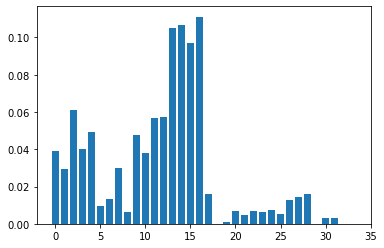

In [10]:
#Finding the most important features
features1 = clf.feature_importances_
print(features1)
plt.bar(x = range(len(features1)), height=features1)
plt.show()

In [11]:
#Fitting most important features to a model
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([ True, False,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

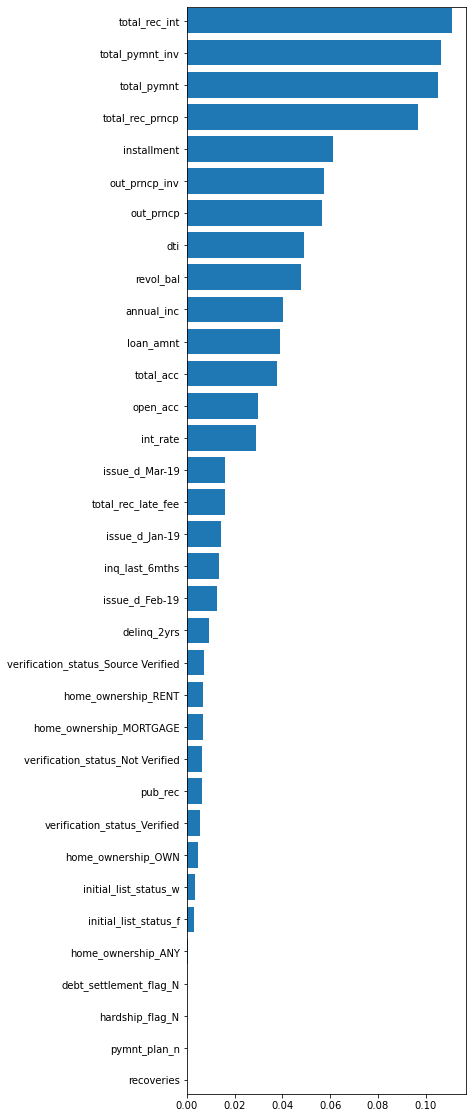

In [12]:
# Use the following code to plot the most important features
features = sorted(zip(X.columns, features1), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(5,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [13]:
#Training and testing the selected features
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [14]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_selected_train, y_train)
Counter(y_resampled)

Counter({1: 51366, 0: 51366})

In [15]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [16]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_selected_test)
balanced_accuracy_score(y_test, y_pred)

0.6204191133566116

In [17]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  73,   28],
       [8243, 8861]], dtype=int64)

In [18]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.01      0.72      0.52      0.02      0.61      0.38       101
          1       1.00      0.52      0.72      0.68      0.61      0.37     17104

avg / total       0.99      0.52      0.72      0.68      0.61      0.37     17205



### SMOTE Oversampling

In [19]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy="auto").fit_resample(
    X_selected_train, y_train
)
Counter(y_resampled)

Counter({1: 51366, 0: 51366})

In [20]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_selected_test)
balanced_accuracy_score(y_test, y_pred)

0.6105461984458502

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  68,   33],
       [7734, 9370]], dtype=int64)

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.01      0.67      0.55      0.02      0.61      0.37       101
          1       1.00      0.55      0.67      0.71      0.61      0.36     17104

avg / total       0.99      0.55      0.67      0.70      0.61      0.36     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [24]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_selected_train, y_train)

In [25]:
Counter(y_resampled)

Counter({0: 246, 1: 246})

In [26]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=78)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=78)

In [27]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.6105461984458502

In [28]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_selected_test)
confusion_matrix(y_test, y_pred)

array([[   79,    22],
       [10212,  6892]], dtype=int64)

In [29]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.01      0.78      0.40      0.02      0.56      0.33       101
          1       1.00      0.40      0.78      0.57      0.56      0.30     17104

avg / total       0.99      0.41      0.78      0.57      0.56      0.30     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [30]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_selected_train, y_train)
Counter(y_resampled)

Counter({0: 50457, 1: 45729})

In [31]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [32]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5925624484805824

In [33]:
# Display the confusion matrix
y_pred = model.predict(X_selected_test)
confusion_matrix(y_test, y_pred)

array([[  74,   27],
       [8818, 8286]], dtype=int64)

In [34]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.01      0.73      0.48      0.02      0.60      0.36       101
          1       1.00      0.48      0.73      0.65      0.60      0.35     17104

avg / total       0.99      0.49      0.73      0.65      0.60      0.35     17205

